In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

random.seed(10)
np.random.seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
config = {
          'batch_size'  : 128,
          'worker'      : 2,
          'epochs'      : 6,
          'momentum'    : 0.9,
          'wd_decay'    : 0.0005,
          'lr'          : 0.01,
          }

cuda


In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]),
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]), 
])

trainset.transform = train_transforms
testset.transform = test_transforms

trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])
testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


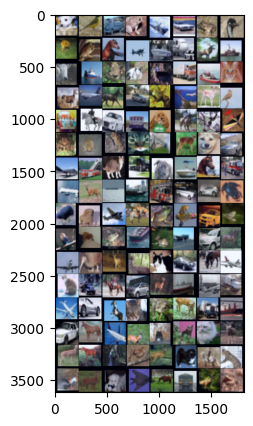

1: dog  	2: bird  	3: truck  	4: frog  	5: airplane	6: automobile	7: frog  	8: bird
9: deer  	10: frog  	11: horse  	12: airplane	13: ship  	14: airplane	15: deer  	16: ship
17: deer  	18: ship  	19: frog  	20: cat  	21: bird  	22: truck  	23: ship  	24: cat
25: deer  	26: airplane	27: horse  	28: automobile	29: frog  	30: airplane	31: deer  	32: bird
33: truck  	34: horse  	35: automobile	36: truck  	37: dog  	38: horse  	39: deer  	40: airplane
41: frog  	42: frog  	43: frog  	44: cat  	45: horse  	46: deer  	47: dog  	48: automobile
49: airplane	50: truck  	51: cat  	52: truck  	53: dog  	54: ship  	55: horse  	56: truck
57: airplane	58: deer  	59: ship  	60: ship  	61: truck  	62: automobile	63: automobile	64: frog
65: bird  	66: dog  	67: airplane	68: horse  	69: frog  	70: airplane	71: automobile	72: frog
73: bird  	74: dog  	75: frog  	76: ship  	77: deer  	78: airplane	79: automobile	80: horse
81: airplane	82: bird  	83: deer  	84: deer  	85: cat  	86: automobile	87: horse  	88

In [4]:

with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

dataiter = iter(trainloader)
images, labels = next(dataiter)
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2, 0))
plt.show()

for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

In [5]:
class SEUnit(nn.Sequential):
    def __init__(self, ch, r=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, int(ch/r), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(int(ch / r), ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
        
class Flatten(nn.Module):
	def forward(self, x):
		return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
	def __init__(self, gate_channels, reduction_ratio=16):
		super(ChannelGate, self).__init__()
		self.gate_channels = gate_channels
		self.mlp = nn.Sequential(
			Flatten(),
			nn.Linear(gate_channels, gate_channels // reduction_ratio),
			nn.ReLU(),
			nn.Linear(gate_channels // reduction_ratio, gate_channels),
			nn.Sigmoid()
			)
		self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
		self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

	def forward(self, x):
		x_avg_pool = self.mlp(self.avgpool(x))
		x_max_pool = self.mlp(self.maxpool(x))
		attention = x_avg_pool + x_max_pool
		attention = attention.unsqueeze(2).unsqueeze(3).expand_as(x)
		return x*attention

class SpatialGate(nn.Module):
	def __init__(self):
		super(SpatialGate, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(2, 1, 7, padding=3),
			nn.BatchNorm2d(1),
			nn.Sigmoid()
			)
            
	def forward(self, x):
		x_avg_pool = torch.mean(x,1).unsqueeze(1)
		x_max_pool = torch.max(x,1)[0].unsqueeze(1)
		attention = torch.cat((x_avg_pool, x_max_pool), dim=1)
		attention = self.conv(attention)
		return x*attention
        

class CBAM_unit(nn.Module):
  def __init__(self, gate_channels, r=16):
    super(CBAM_unit, self).__init__()
    self.ChannelGate = ChannelGate(gate_channels, r)
    self.SpatialGate = SpatialGate()

  def forward(self, x):
    x = self.ChannelGate(x)
    x = self.SpatialGate(x)
    return x

class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, SENet = False, CBAM=False):
        super().__init__()
        self.se = SENet
        self.cb = CBAM
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size = 1, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )
        self.residual_function_se = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size = 1, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
            SEUnit(out_channels*BottleNeck.expansion)
        )
        self.residual_function_cb = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size = 1, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
            CBAM_unit(out_channels * BottleNeck.expansion)
        )

        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride = stride, kernel_size = 1, bias = False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
    
    def forward(self, x):
        if self.se:
          x= self.residual_function_se(x) + self.shortcut(x)
        elif self.cb:
          x = self.residual_function_cb(x) + self.shortcut(x)
        else:
          x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=10, SENet = False, CBAM = False):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1,SENet,CBAM)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2,SENet,CBAM)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2,SENet,CBAM)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2,SENet,CBAM)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride,SENet=False, CBAM= False):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride,SENet,CBAM))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(BottleNeck, [2, 2, 2, 2])

def ResNet18_SE():
    return ResNet(BottleNeck, [2, 2, 2, 2],SENet= True)

def ResNet18_CBAM():
    return ResNet(BottleNeck, [2, 2, 2, 2],CBAM= True)

In [6]:
def get_model(model_name):
    if model_name == 'ResNet18':
        print("Resnet18")
        return ResNet18()
    elif model_name == 'ResNet18_SE':
        print("Resnet_SE")
        return ResNet18_SE()
    elif model_name == 'ResNet18_CBAM':
        print("CBAM")
        return ResNet18_CBAM()
    else:
        raise Exception(f"{model_name} is not supported yet")

loss_list =[]




for model_name in ['ResNet18', 'ResNet18_SE', 'ResNet18_CBAM']:
    model = get_model(model_name).to(device)
    model = model.to(memory_format=torch.channels_last)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params=model.parameters(), lr = config['lr'], momentum=config['momentum'], weight_decay=config['wd_decay'])

    for epoch in range(config['epochs']): 

        running_loss = 0.0
        start_time = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = inputs.to(memory_format=torch.channels_last)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast(True):
                output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            end_time = time.time()
            time_taken = end_time - start_time
            time_taken = str(time_taken/60).split('.')
            
        print('Epoch: {}/{}, train_loss: {:.4f}, time:{}m {}s'.format(epoch + 1, config['epochs'], running_loss / len(trainset), time_taken[0], time_taken[1][:2]))
        loss_list.append(running_loss / len(trainset))
    print(f'Finished Training of {model_name}')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the {model_name} on the 10000 test images: {100 * correct / total:.2f}%')

Resnet18
Epoch: 1/6, train_loss: 0.0133, time:2m 04s
Epoch: 2/6, train_loss: 0.0089, time:1m 95s
Epoch: 3/6, train_loss: 0.0069, time:2m 08s
Epoch: 4/6, train_loss: 0.0058, time:2m 09s
Epoch: 5/6, train_loss: 0.0050, time:2m 05s
Epoch: 6/6, train_loss: 0.0044, time:2m 08s
Finished Training of ResNet18
Accuracy of the ResNet18 on the 10000 test images: 72.02%
Resnet_SE
Epoch: 1/6, train_loss: 0.0129, time:2m 20s
Epoch: 2/6, train_loss: 0.0091, time:2m 20s
Epoch: 3/6, train_loss: 0.0073, time:2m 21s
Epoch: 4/6, train_loss: 0.0062, time:2m 21s
Epoch: 5/6, train_loss: 0.0052, time:2m 21s
Epoch: 6/6, train_loss: 0.0046, time:2m 21s
Finished Training of ResNet18_SE
Accuracy of the ResNet18_SE on the 10000 test images: 75.40%
CBAM
Epoch: 1/6, train_loss: 0.0125, time:3m 46s
Epoch: 2/6, train_loss: 0.0087, time:3m 46s
Epoch: 3/6, train_loss: 0.0072, time:3m 46s
Epoch: 4/6, train_loss: 0.0063, time:3m 46s
Epoch: 5/6, train_loss: 0.0054, time:3m 45s
Epoch: 6/6, train_loss: 0.0048, time:3m 46s
Fi

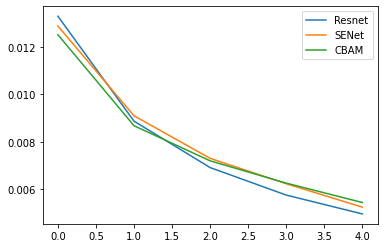

In [7]:
ResNet_loss =[]
SENet_loss = []
CBAM_loss = [] 

ResNet_loss = loss_list[0:5:]
SENet_loss = loss_list[6:11:]
CBAM_loss = loss_list[12:17:]

plt.plot(ResNet_loss, label='Resnet')
plt.plot(SENet_loss,label='SENet')
plt.plot(CBAM_loss, label='CBAM')
plt.legend()
plt.show()